# AutoJudge: Advanced Model Exploration & Web Interface

This notebook covers the end-to-end pipeline for the AutoJudge system:
1. **Data Preprocessing**: Cleaning and combining Codeforces, LeetCode, and Kattis datasets.
2. **Feature Extraction**: Converting text to numerical features using TF-IDF.
3. **Model Training & Comparison**: Training multiple models for Classification (Difficulty) and Regression (Score).
4. **Evaluation**: Using Accuracy, Confusion Matrix, MAE, and RMSE.
5. **Web Interface**: Interactive widget to test the model with custom inputs.

In [7]:
import pandas as pd
import numpy as np
import joblib
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, confusion_matrix
import ipywidgets as widgets
from IPython.display import display

# Ensure NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

## 1. Data Loading
We load datasets from three sources: Codeforces (`problems_data.jsonl`), LeetCode, and Kattis.

In [8]:
# Paths
original_path = '../problems_data.jsonl' # Codeforces data
leetcode_path = '../leetcode_dataset.csv'
kattis_path = '../kattis_dataset.csv'

# 1. Load Original Data (Codeforces)
try:
    df_orig = pd.read_json(original_path, lines=True)
except ValueError:
    df_orig = pd.read_json(original_path)

# 2. Load LeetCode Data
df_leet = pd.read_csv(leetcode_path)

# 3. Load Kattis Data
df_kattis = pd.read_csv(kattis_path, usecols=['question', 'difficulty'])

print(f"Original Data: {df_orig.shape}")
print(f"LeetCode Data: {df_leet.shape}")
print(f"Kattis Data: {df_kattis.shape}")

Original Data: (4112, 8)
LeetCode Data: (1825, 19)
Kattis Data: (5000, 2)


## 2. Data Cleaning & Preprocessing
- Combine relevant text fields (Title, Description, Input, Output).
- Map difficulty levels to standard Classes (Easy, Medium, Hard) and Scores (1, 2, 3).
- Clean text (remove HTML, special chars, stopwords).

In [9]:
# --- Process Original (Codeforces) ---
df_orig['combined_text'] = df_orig['title'].fillna('') + " " + df_orig['description'].fillna('') + " " + df_orig['input_description'].fillna('') + " " + df_orig['output_description'].fillna('')
df_orig = df_orig[['combined_text', 'problem_class', 'problem_score']].copy()

# --- Process LeetCode ---
df_leet['combined_text'] = df_leet['title'].fillna('') + " " + df_leet['description'].fillna('')
# Map Difficulty
difficulty_map = {'Easy': 'Easy', 'Medium': 'Medium', 'Hard': 'Hard'}
score_map = {'Easy': 1, 'Medium': 2, 'Hard': 3}
df_leet['problem_class'] = df_leet['difficulty'].map(difficulty_map)
df_leet['problem_score'] = df_leet['difficulty'].map(score_map)
df_leet = df_leet[['combined_text', 'problem_class', 'problem_score']].copy()

# --- Process Kattis ---
df_kattis = df_kattis.rename(columns={'question': 'combined_text'})
# Map Kattis Difficulty
kattis_map = {'introductory': 'Easy', 'interview': 'Medium', 'competition': 'Hard'}
kattis_score = {'introductory': 1, 'interview': 2, 'competition': 3}
df_kattis['problem_class'] = df_kattis['difficulty'].map(kattis_map)
df_kattis['problem_score'] = df_kattis['difficulty'].map(kattis_score)
df_kattis = df_kattis[['combined_text', 'problem_class', 'problem_score']].dropna().copy()

# --- Merge All ---
df_final = pd.concat([df_orig, df_leet, df_kattis], ignore_index=True)
print(f"Combined Dataset Size: {df_final.shape}")

# Text Cleaning Function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML
    text = re.sub(r'[^a-z0-9\s$]', '', text) # Keep math symbols ($), remove others
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

print("Cleaning text (this may take a while)...")
df_final['cleaned_text'] = df_final['combined_text'].apply(clean_text)
print("Data cleaning complete.")

Combined Dataset Size: (10937, 3)
Cleaning text (this may take a while)...
Data cleaning complete.


## 3. Feature Extraction
We extract explicit features (length, word count) and use TF-IDF for text features.

In [10]:
df_final['text_len'] = df_final['combined_text'].apply(len)
df_final['word_count'] = df_final['combined_text'].apply(lambda x: len(str(x).split()))
df_final['math_symbol_count'] = df_final['combined_text'].apply(lambda x: str(x).count('$'))

X = df_final[['cleaned_text', 'text_len', 'word_count', 'math_symbol_count']]
y_class = df_final['problem_class']
y_score = df_final['problem_score']

# Split Data
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X, y_class, y_score, test_size=0.2, random_state=42
)

## 4. Model Training & Selection
We will train multiple models and compare their performance.

In [11]:
# Preprocessing Pipeline
text_features = 'cleaned_text'
numeric_features = ['text_len', 'word_count', 'math_symbol_count']

text_transformer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2)) # Improved TF-IDF
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_features),
        ('num', numeric_transformer, numeric_features)
    ])

# --- Classification Models ---
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True)
}

# --- Regression Models ---
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

### 4.1 Evaluate Classification Models

--- Classification Results ---
Logistic Regression Accuracy: 0.5841
Random Forest Accuracy: 0.6188
SVM Accuracy: 0.5983

Best Classification Model: Random Forest with Accuracy: 0.6188


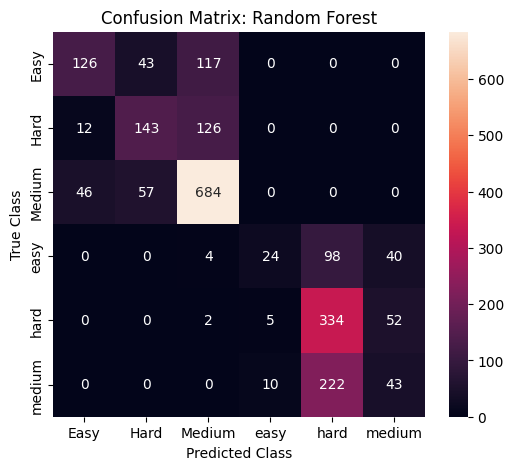

In [12]:
best_clf_score = 0
best_clf_pipeline = None
best_clf_name = ""

print("--- Classification Results ---")
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', clf)])
    pipeline.fit(X_train, y_class_train)
    y_pred = pipeline.predict(X_test)
    score = accuracy_score(y_class_test, y_pred)
    print(f"{name} Accuracy: {score:.4f}")
    
    if score > best_clf_score:
        best_clf_score = score
        best_clf_pipeline = pipeline
        best_clf_name = name

print(f"\nBest Classification Model: {best_clf_name} with Accuracy: {best_clf_score:.4f}")

# Confusion Matrix for Best Model
y_pred_best = best_clf_pipeline.predict(X_test)
cm = confusion_matrix(y_class_test, y_pred_best, labels=best_clf_pipeline.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=best_clf_pipeline.classes_, yticklabels=best_clf_pipeline.classes_)
plt.title(f'Confusion Matrix: {best_clf_name}')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

### 4.2 Evaluate Regression Models

In [13]:
best_reg_score = float('inf') # MAE, lower is better
best_reg_pipeline = None
best_reg_name = ""

print("--- Regression Results ---")
for name, reg in regressors.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', reg)])
    pipeline.fit(X_train, y_score_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_score_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_score_test, y_pred))
    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    if mae < best_reg_score:
        best_reg_score = mae
        best_reg_pipeline = pipeline
        best_reg_name = name

print(f"\nBest Regression Model: {best_reg_name} with MAE: {best_reg_score:.4f}")

--- Regression Results ---
Linear Regression -> MAE: 1.2476, RMSE: 1.6415
Random Forest Regressor -> MAE: 0.9409, RMSE: 1.3932
Gradient Boosting -> MAE: 0.9997, RMSE: 1.4459

Best Regression Model: Random Forest Regressor with MAE: 0.9409


## 5. Save Best Models

In [14]:
joblib.dump(best_clf_pipeline, '../model_class.pkl')
joblib.dump(best_reg_pipeline, '../model_score.pkl')
print("Best models saved successfully.")

Best models saved successfully.


## 6. Web Interface (Preview)
Test the model interactively.

In [ ]:
# Widgets
style = {'description_width': 'initial'}

prob_desc = widgets.Textarea(description='Problem Description:', placeholder='Enter problem text...', layout=widgets.Layout(width='90%', height='100px'), style=style)
input_desc = widgets.Textarea(description='Input Description:', placeholder='Input specs...', layout=widgets.Layout(width='90%', height='60px'), style=style)
output_desc = widgets.Textarea(description='Output Description:', placeholder='Output specs...', layout=widgets.Layout(width='90%', height='60px'), style=style)

button = widgets.Button(description="Predict Difficulty", button_style='info')
output_area = widgets.Output()

def on_click_predict(b):
    with output_area:
        output_area.clear_output()
        # Combine Inputs
        full_text = prob_desc.value + " " + input_desc.value + " " + output_desc.value
        cleaned = clean_text(full_text)
        
        # Create DataFrame for prediction
        sample_df = pd.DataFrame([{
            'cleaned_text': cleaned,
            'text_len': len(full_text),
            'word_count': len(full_text.split()),
            'math_symbol_count': full_text.count('$')
        }])
        
        # Predict
        pred_class = best_clf_pipeline.predict(sample_df)[0]
        pred_score = best_reg_pipeline.predict(sample_df)[0]
        
        print(f"Predicted Difficulty: {pred_class}")
        print(f"Predicted Score: {pred_score:.2f}")

button.on_click(on_click_predict)

display(prob_desc, input_desc, output_desc, button, output_area)

Textarea(value='', description='Problem Description:', layout=Layout(height='100px', width='90%'), placeholder…

Textarea(value='', description='Input Description:', layout=Layout(height='60px', width='90%'), placeholder='I…

Textarea(value='', description='Output Description:', layout=Layout(height='60px', width='90%'), placeholder='…

Button(button_style='info', description='Predict Difficulty', style=ButtonStyle())

Output()